In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import measure
from scipy.ndimage import label
import os

In [25]:
# Step 1: Preprocess the input image
def preprocess_image(image_path, img_size=(256, 256)):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image
    image_resized = cv2.resize(image, img_size)
    # Normalize pixel values
    image_normalized = image_resized / 255.0
    return image_normalized

In [26]:
# Step 2: Region-growing algorithm
def region_growing(image, seeds, threshold=0.1):
    # Get the image dimensions
    h, w = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)  # Output mask for the segmented region
    
    # Define the connectivity (4-connectivity: up, down, left, right)
    connectivity = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    # List of seeds to process
    seed_list = seeds[:]
    
    # Grow region from each seed
    while seed_list:
        x, y = seed_list.pop(0)
        
        # Check if the pixel is already segmented
        if segmented[x, y] == 1:
            continue
        
        # Mark the pixel as part of the segmented region
        segmented[x, y] = 1
        
        # Get the intensity value of the current pixel
        pixel_value = image[x, y]
        
        # Expand to neighbors
        for dx, dy in connectivity:
            xn, yn = x + dx, y + dy
            if 0 <= xn < h and 0 <= yn < w and segmented[xn, yn] == 0:
                # Check if the neighboring pixel is within the intensity threshold
                if abs(image[xn, yn] - pixel_value) < threshold:
                    seed_list.append((xn, yn))
    
    return segmented


In [33]:
# Step 3: Heuristic for selecting seeds
def select_seeds(image):
    """
    Manually selects two seeds for the kidneys. In a real-world scenario,
    this would either be provided by a user or determined heuristically.
    """
    h, w = image.shape
    
    # Heuristic to select left and right kidney seeds: choose middle-left and middle-right
    # left_seed = (h // 2, w // 3)  # Approximate location of left kidney
    # right_seed = (h // 2, 2 * w // 3)  # Approximate location of right kidney
    left_seed = (150, 60)
    right_seed = (150, 185)
    
    return [left_seed, right_seed]

In [34]:
# Step 4: Post-process to separate left and right kidneys
def separate_kidneys(segmentation_mask):
    # Label connected regions in the segmentation mask
    labeled_mask, num_labels = label(segmentation_mask)
    
    if num_labels != 2:
        print(f"Warning: Expected 2 kidneys, found {num_labels}")
    
    # Get properties of labeled regions
    regions = measure.regionprops(labeled_mask)
    
    if len(regions) == 2:
        # Sort regions based on centroids (left kidney should be left-most)
        regions = sorted(regions, key=lambda x: x.centroid[1])
        left_kidney = labeled_mask == regions[0].label
        right_kidney = labeled_mask == regions[1].label
        return left_kidney, right_kidney
    
    elif len(regions) == 1:
        # If only one region is found, assume it is the left kidney
        left_kidney = labeled_mask == regions[0].label
        right_kidney = np.zeros_like(segmentation_mask)
        return left_kidney, right_kidney

    else:
        return None, None

In [35]:
# Step 5: Visualize the results
# def visualize_results(image, left_kidney, right_kidney, seed_points):
#     plt.figure(figsize=(15, 5))

#     plt.subplot(1, 3, 1)
#     plt.imshow(image, cmap='gray')
#     plt.scatter([p[1] for p in seed_points], [p[0] for p in seed_points], c='r', marker='x', s=100)
#     plt.title('Original Image')
    
#     plt.subplot(1, 3, 2)
#     plt.imshow(left_kidney, cmap='gray')
#     plt.scatter(seed_points[0][1], seed_points[0][0], c='r', marker='x', s=100)
#     plt.title('Left Kidney')

#     plt.subplot(1, 3, 3)
#     plt.imshow(right_kidney, cmap='gray')
#     plt.scatter(seed_points[1][1], seed_points[1][0], c='r', marker='x', s=100)
#     plt.title('Right Kidney')

#     plt.show()

def visualize_results(image, left_kidney, right_kidney, seed_points):
    # Create a color version of the original grayscale image
    left_kidney_color_image = np.stack((image,)*3, axis=-1)
    right_kidney_color_image = np.stack((image,)*3, axis=-1)
    
    # Overlay the left kidney mask in red
    left_kidney_color_image[left_kidney > 0] = [255, 0, 0]
    
    # Overlay the right kidney mask in blue
    right_kidney_color_image[right_kidney > 0] = [0, 0, 255]
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.scatter([p[1] for p in seed_points], [p[0] for p in seed_points], c='w', marker='x', s=100)
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(left_kidney_color_image)
    plt.scatter(seed_points[0][1], seed_points[0][0], c='w', marker='x', s=100)
    plt.title('Left Kidney Overlay')

    plt.subplot(1, 3, 3)
    plt.imshow(right_kidney_color_image)
    plt.scatter(seed_points[1][1], seed_points[1][0], c='w', marker='x', s=100)
    plt.title('Right Kidney Overlay')

In [36]:
# Step 6: Save generated masks
def save_kidney_masks(left_kidney, right_kidney, mask_filename):
    # Convert boolean masks to uint8 images (0 or 255)
    left_kidney_image = (left_kidney * 255).astype(np.uint8)
    right_kidney_image = (right_kidney * 127).astype(np.uint8)
    combined_image = left_kidney_image + right_kidney_image
    
    # Save images in .jpg format
    cv2.imwrite(mask_filename, combined_image)

In [37]:
# Main function to run the region-growing pipeline
def main(image_path, output_path):
    # Step 1: Preprocess the image
    image = preprocess_image(image_path)
    
    # Step 2: Select seeds (for left and right kidneys)
    seeds = select_seeds(image)
    
    # Step 3: Apply region growing
    region_mask = region_growing(image, seeds, threshold=0.02)
    
    # Step 4: Separate left and right kidneys
    left_kidney, right_kidney = separate_kidneys(region_mask)
    
    # Step 5: Visualize the results
    if left_kidney is not None and right_kidney is not None:
        visualize_results(image, left_kidney, right_kidney, seeds)
    else:
        print("Failed to detect two separate kidneys.")

    # Step 6: Save the generated masks
    save_kidney_masks(left_kidney, right_kidney, output_path)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


C:\Users\320194082\AppData\Local\Temp\ipykernel_28892\2290308364.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 5))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for flo

KeyboardInterrupt: 

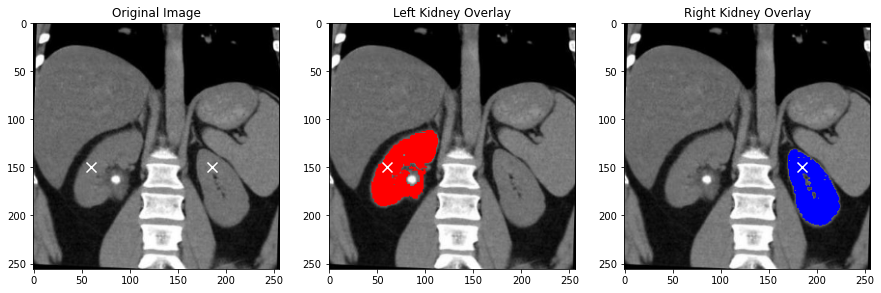

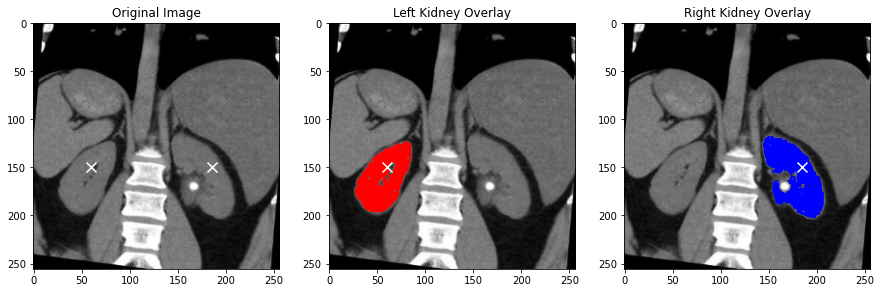

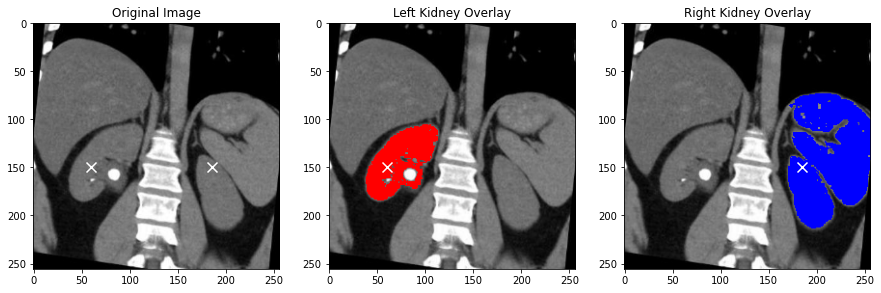

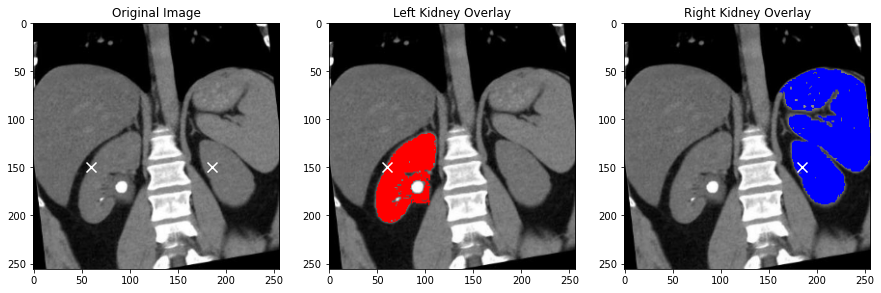

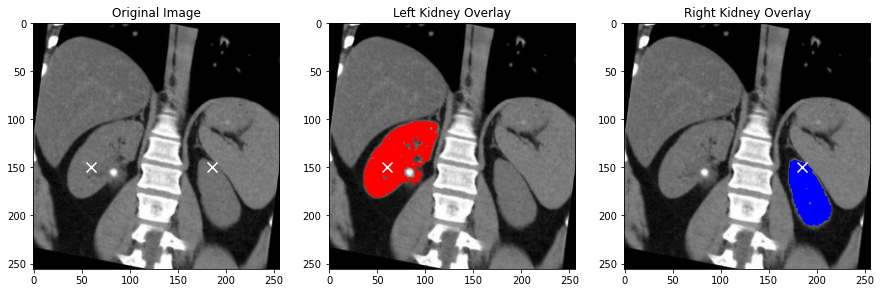

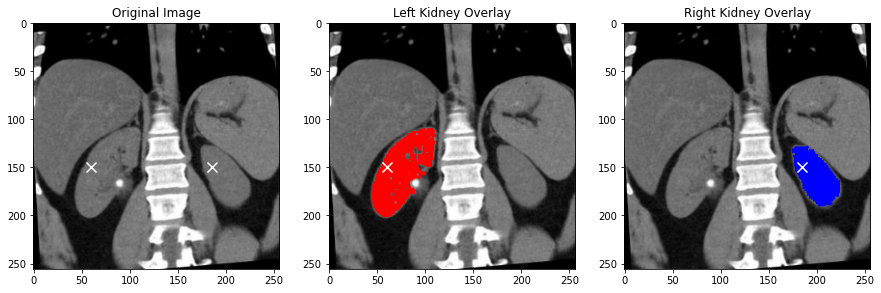

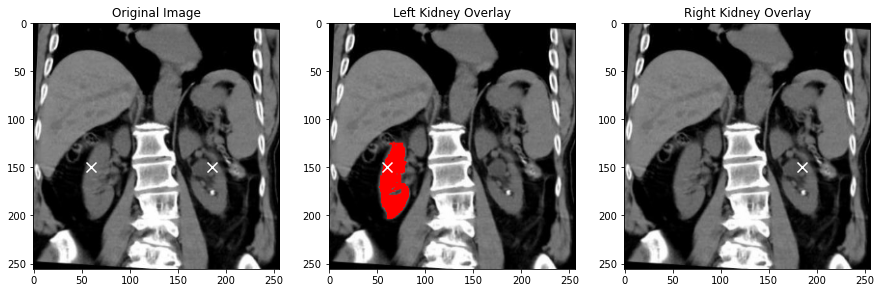

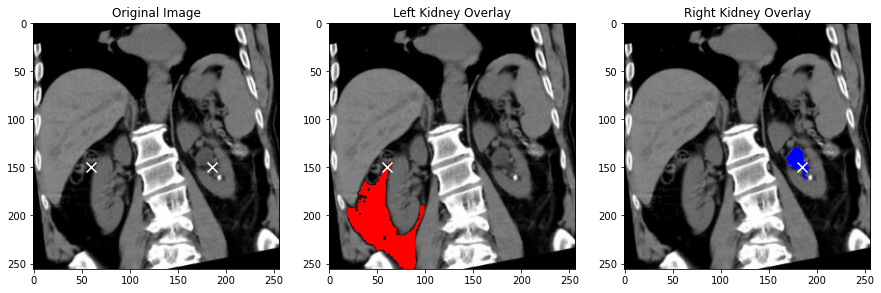

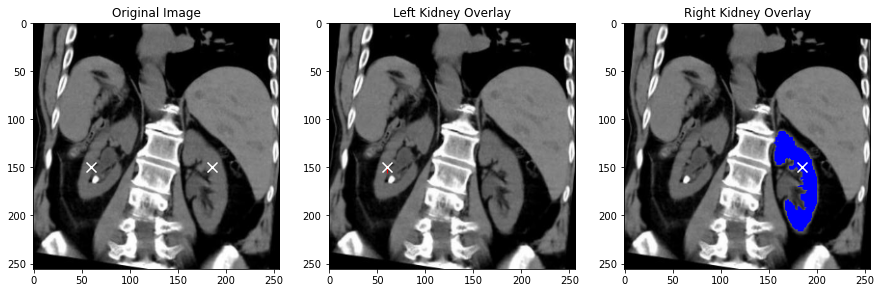

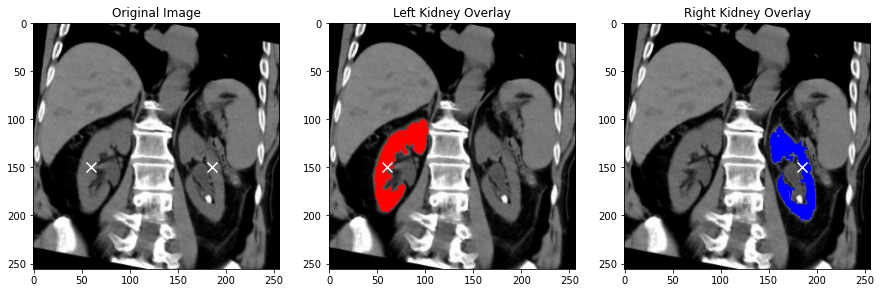

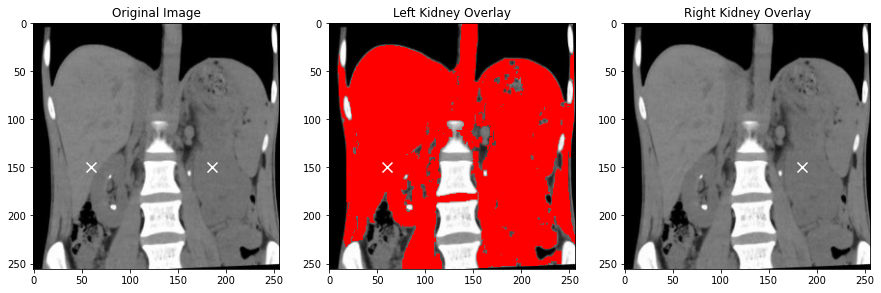

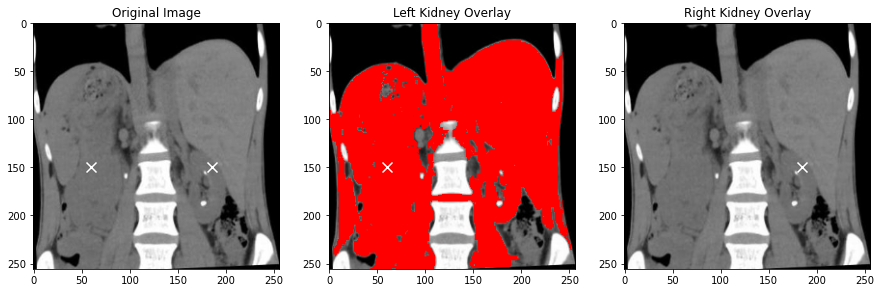

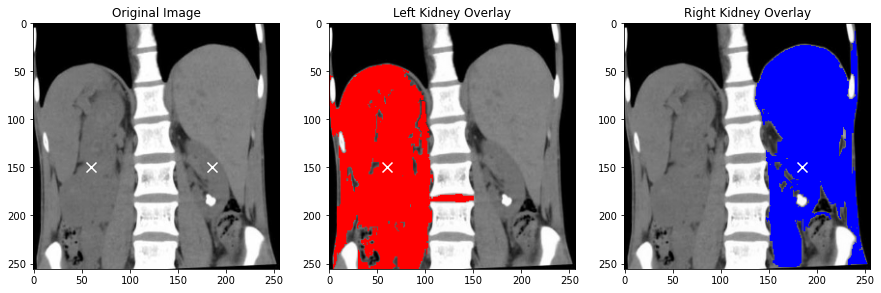

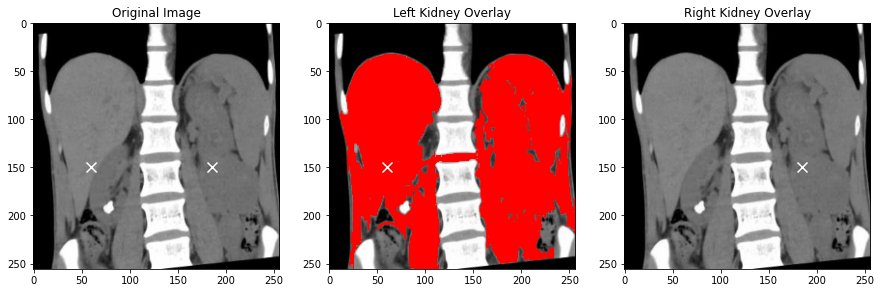

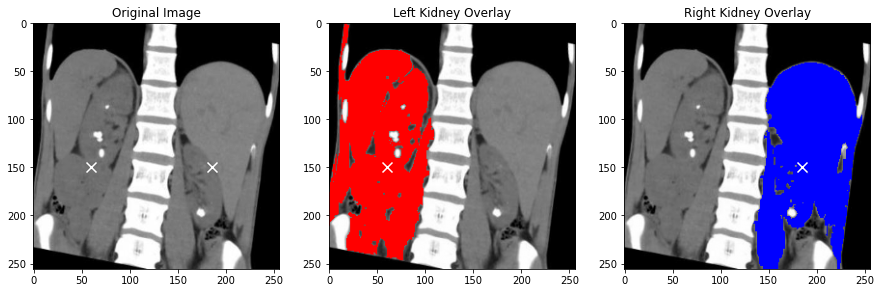

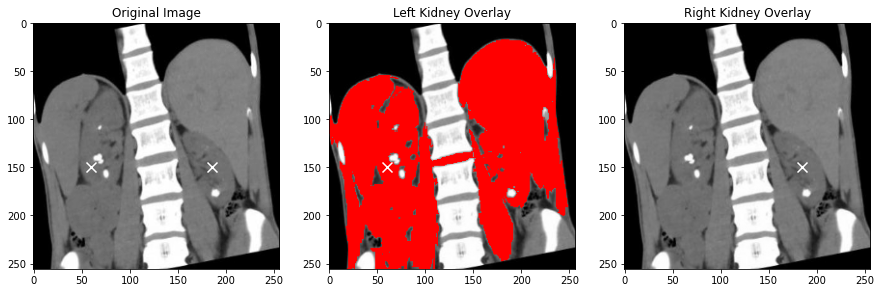

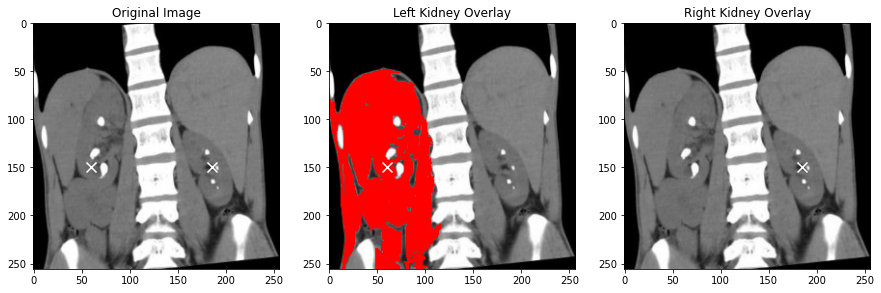

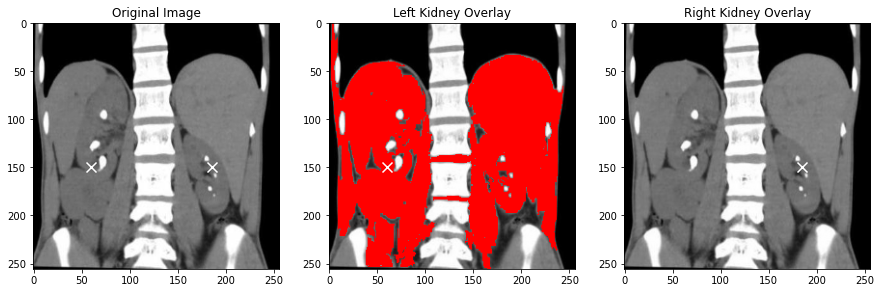

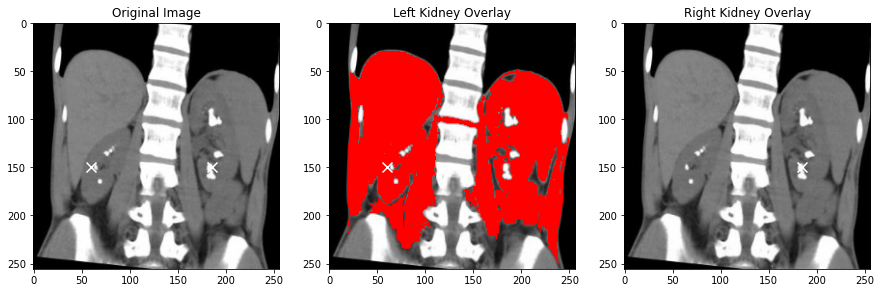

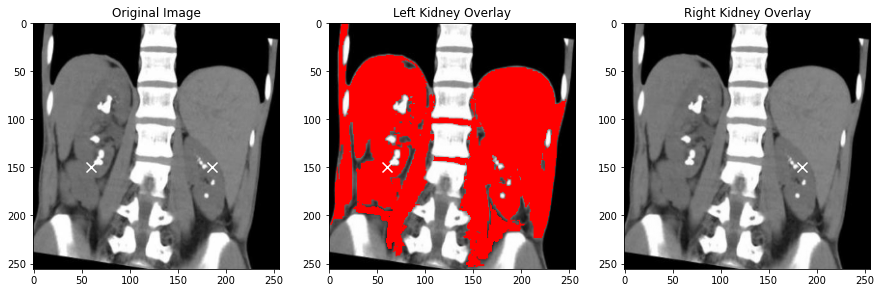

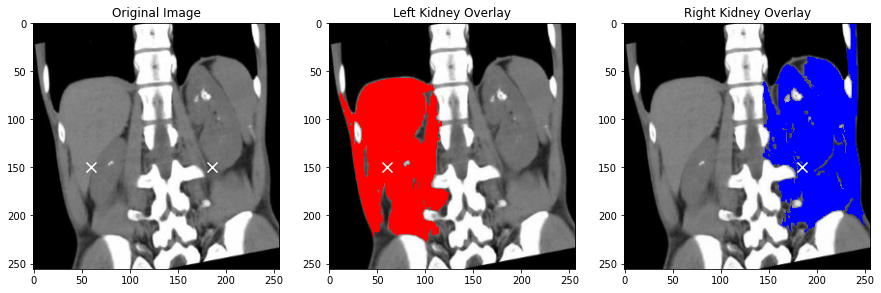

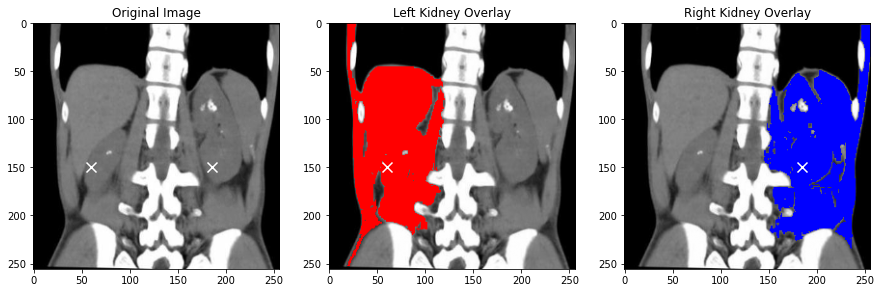

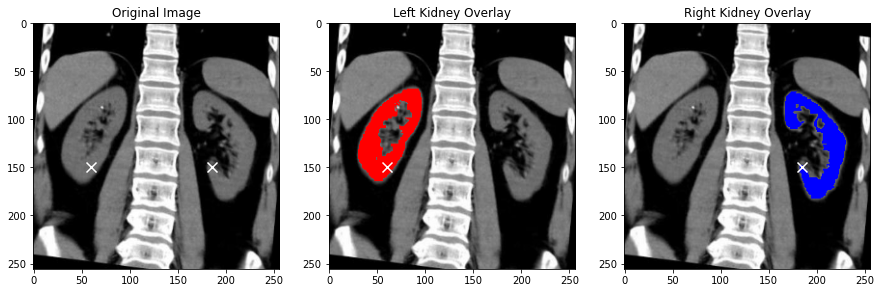

In [40]:
# Example usage
if __name__ == "__main__":
    image_dir_path = "../data/train/images"
    output_dir_path = "../output"
    for image_file in os.listdir(image_dir_path)[:]:
        if image_file.endswith(".jpg"):
            image_file_path = os.path.join(image_dir_path, image_file)
            output_file = image_file.replace(".jpg", "_mask.png")
            output_file_path = os.path.join(output_dir_path, output_file)
            main(image_file_path, output_file_path)
    # image_file = "1-3-46-670589-33-1-63700700749865510700001-5062181202000819812_png_jpg.rf.74493ef7bdab6de49e88f708a5745000.jpg"
    # output_file = image_file.replace(".jpg", "_mask.jpg")
    # image_file_path = os.path.join(image_dir_path, image_file)
    # output_file_path = os.path.join(output_dir_path, output_file)
    # main(image_file_path, output_file_path)